# NYSE & Blurr

In this guide we will train a machine learning model that predicts closing price of a stock based on historical data. We will transform time-series stock data into features to train this model. 

## Prerequisites

It's recommended to have a basic understanding of how Blurr works. Following [tutorials 1](http://productml-blurr.readthedocs.io/en/latest/Streaming%20DTC%20Tutorial/) and [2](http://productml-blurr.readthedocs.io/en/latest/Window%20DTC%20Tutorial/) should provide enough background context.


## Preparation

Let's start by installing `Blurr` and other required dependencies:

In [44]:
import sys

print("installing blurr, keras and tensorflow...")
!{sys.executable} -m pip install blurr --quiet
!{sys.executable} -m pip install keras --quiet
!{sys.executable} -m pip install tensorflow --quiet
print("done.")

installing blurr, keras and tensorflow...
done.


## The Dataset

This walkthrough is based on [New York Stock Exchange Data](https://www.kaggle.com/dgawlik/nyse/data) made available for [Kaggle challenges](https://www.kaggle.com/dgawlik/nyse).

Let's start by downloading and having a peek at the available data: 

In [51]:
!wget http://demo.productml.com/data/nyse-input-data.json.zip
!unzip -o nyse-input-data.json.zip -d .

--2018-05-12 02:07:35--  http://demo.productml.com/data/nyse-input-data.json.zip
Resolving demo.productml.com (demo.productml.com)... 54.231.169.27
Connecting to demo.productml.com (demo.productml.com)|54.231.169.27|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3941552 (3.8M) [application/zip]
Saving to: 'nyse-input-data.json.zip'

nyse-input-data.jso 100%[===================>]   3.76M  1.51MB/s    in 2.5s    

2018-05-12 02:07:38 (1.51 MB/s) - 'nyse-input-data.json.zip' saved [3941552/3941552]

Archive:  nyse-input-data.json.zip
  inflating: ./nyse-input-data.json  


In [52]:
import pandas as pd

stocks = pd.read_json("./nyse-input-data.json", lines=True)
stocks.head()

,datetime,price,symbol,volume
0,2010-01-04 16:13:57,30.340000,AAPL,18286281
1,2010-01-04 14:05:17,30.642857,AAPL,18857727
2,2010-01-04 02:10:17,30.490000,AAPL,40572687
3,2010-01-04 20:52:52,30.572857,AAPL,571446
4,2010-01-04 10:53:39,30.461485,AAPL,25143637


This dataset contains data for each market day.

Our **goal is to predict closing price** of a stock for any given day based on historical data. In order to do that, we need to transform our original data source into **features** that can be used for training.

We'll calculate **moving averages** and other aggregate data for different **time windows**: one, three and seven days.

## Blurr Templates

We perform initial aggregations of our data by day with [nyse-streaming-dtc.yml](./nyse-streaming-dtc.yml). Features are then computed using [nyse-window-dtc.yml](./nyse-window-dtc.yml) for each stock per day.

In [53]:
!cat 'nyse-streaming-dtc.yml'

Type: 'Blurr:Transform:Streaming'
Version: '2018-03-01'
Description: New York Store Exchange Transformations
Name: nyse

Import:
  - { Module: dateutil.parser, Identifiers: [ parse ]}

Identity: source.symbol

Time: parse(source.datetime)

Stores:
  - Type: 'Blurr:Store:Memory'
    Name: memory

Aggregates:
  - Type: 'Blurr:Aggregate:Block'
    Name: stats
    Store: memory
    Split: time.date() != stats.latest_tradetime.date()
    When: source.symbol in ['AAPL', 'MSFT', 'GOOG', 'FB']
    Fields:
      - Name: close
        Type: float
        Value: source.price

      - Name: high
        Type: float
        Value: source.price
        When: source.price >= stats.high
    
      - Name: low
        Type: float
        Value: source.price
        When: (stats.low == 0 or source.price < stats.low)

      - Name: volatility
        Type: float
        Value: (float(stats.high) / float(stats.low)) - 1
        When: stats.low > 0

      - Name: volume
        Type: float
        Value: s

**Streaming DTC**

We're predicting values for tech companies only (Apple, Facebook, Microsoft, Google):

```yaml
When: source.symbol in ['AAPL', 'MSFT', 'GOOG', 'FB']
```

Each record in the original dataset represents a single stock transaction. By setting `Split: time.date() != stats.latest_tradetime.date()` we'll create a new aggregate for each day per stock.


In [54]:
!cat 'nyse-window-dtc.yml'

Type: Blurr:Transform:Window
Version: '2018-03-01'
Name: moving_averages

SourceDTC: nyse

Anchor:
  Condition: nyse.stats.volatility < 0.04

Aggregates:


  - Type: Blurr:Aggregate:Window
    Name: close
    WindowType: count
    WindowValue: 1
    Source: nyse.stats
    Fields:
    - Name: value
      Type: float
      Value: anchor.close # the anchor object represents the record that matches the anchor condition

  - Type: Blurr:Aggregate:Window
    Name: last
    WindowType: count
    WindowValue: -1
    Source: nyse.stats
    Fields:
    - Name: close
      Type: float
      Value: source.close[0]
    - Name: volume
      Type: float
      Value: source.volume[0]
    - Name: volatility
      Type: float
      Value: source.volatility[0]

  - Type: Blurr:Aggregate:Window
    Name: last_3
    WindowType: count
    WindowValue: -3
    Source: nyse.stats
    Fields:
    - Name: close_avg
      Type: float
      Value: sum(source.close) / len(source.close)
    - Name: volume_avg
      

**Window DTC**

We'll use a very rough criteria to remove outliers: our model will only work when closing price changes less than a 4%:

```yaml
Anchor:
  Condition: nyse.stats.volatility < 0.04
```

We're using [moving averages](https://www.investopedia.com/terms/m/movingaverage.asp) to generate features based on historical data about a stock:

```yaml
- Type: Blurr:Aggregate:Window
    Name: last_7
    WindowType: count
    WindowValue: -7
    Source: nyse.stats
    Fields:
    - Name: close_avg
      Type: float
      Value: sum(source.close) / len(source.close)
```


## Transforming Data



In [16]:
from blurr_util import print_head, validate, transform

validate('nyse-streaming-dtc.yml')
validate('nyse-window-dtc.yml')

Running syntax validation on nyse-streaming-dtc.yml
Document is valid
Running syntax validation on nyse-window-dtc.yml
Document is valid


Let's run our Streaming DTC for informational purposes only, so we can preview the result of the transformation:

In [20]:
transform(log_files=["./nyse-input-data.json"],
          stream_dtc='./nyse-streaming-dtc.yml',
          output_file="./nyse-streaming-dtc-out.log")

In [9]:
print_head("./nyse-streaming-dtc-out.log")

In [21]:
transform(log_files=["./nyse-input-data.json"],
          stream_dtc='./nyse-streaming-dtc.yml',
          window_dtc='./nyse-window-dtc.yml',
          output_file="./nyse-processed-data.csv")

Let's now preview the data that will be used to **train our model**

In [17]:
window_out = pd.read_csv("./nyse-processed-data.csv")
window_out.head()

,close._identity,close.value,last._identity,last.close,last.volatility,last.volume,last_3._identity,last_3.close_avg,last_3.max_volatility,last_3.min_volatility,last_3.volatility_avg,last_3.volume_avg,last_7._identity,last_7.close_avg,last_7.max_volatility,last_7.min_volatility,last_7.volatility_avg,last_7.volume_avg
0,AAPL,30.092857,AAPL,29.674286,0.016229,148614899.0,AAPL,29.990953,0.021828,0.014063,0.017373,1.253583e+08,AAPL,30.198979,0.021828,0.009982,0.015492,1.296152e+08
1,AAPL,29.918571,AAPL,30.092857,0.033464,151472998.0,AAPL,29.927619,0.033464,0.016229,0.023840,1.385484e+08,AAPL,30.130408,0.033464,0.010973,0.018847,1.336210e+08
2,AAPL,29.418571,AAPL,29.918571,0.006889,108223496.0,AAPL,29.895238,0.033464,0.006889,0.018861,1.361038e+08,AAPL,30.029388,0.033464,0.006889,0.018263,1.275849e+08
3,AAPL,30.719999,AAPL,29.418571,0.027833,148516895.0,AAPL,29.810000,0.033464,0.006889,0.022729,1.360711e+08,AAPL,29.926531,0.033464,0.006889,0.019203,1.290816e+08
4,AAPL,30.247143,AAPL,30.719999,0.038361,182501897.0,AAPL,30.019047,0.038361,0.006889,0.024361,1.464141e+08,AAPL,30.017551,0.038361,0.006889,0.022667,1.381129e+08


## Modelling

**Blurr** is about Data Preparation and Feature Engineering. Modeling is included here for illustration purpose, and the reader can use any modeling library or tool for such purpose.

Let's start by importing the output of our Window DTC as the source dataset. We're dropping unnecessary `_identity` columns:

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def import_dataset():
    data = pd.read_csv("./nyse-processed-data.csv")
    data["close"] = data["close.value"] # Moving close to the last column
    data.drop(['close.value'], 1, inplace=True) 
    data.drop(['close._identity'], 1, inplace=True) 
    data.drop(['last._identity'], 1, inplace=True) 
    data.drop(['last_3._identity'], 1, inplace=True) 
    data.drop(['last_7._identity'], 1, inplace=True) 
    return data

dataset = import_dataset()
dataset.head()

,last.close,last.volatility,last.volume,last_3.close_avg,last_3.max_volatility,last_3.min_volatility,last_3.volatility_avg,last_3.volume_avg,last_7.close_avg,last_7.max_volatility,last_7.min_volatility,last_7.volatility_avg,last_7.volume_avg,close
0,29.674286,0.016229,148614895.0,29.990953,0.021828,0.014063,0.017373,1.253583e+08,30.198979,0.021828,0.009982,0.015492,1.296152e+08,30.092857
1,30.092857,0.033464,151472995.0,29.927619,0.033464,0.016229,0.023840,1.385484e+08,30.130408,0.033464,0.010973,0.018847,1.336210e+08,29.918571
2,29.918571,0.006889,108223497.0,29.895238,0.033464,0.006889,0.018861,1.361038e+08,30.029388,0.033464,0.006889,0.018263,1.275849e+08,29.418571
3,29.418571,0.027833,148516897.0,29.810000,0.033464,0.006889,0.022729,1.360711e+08,29.926531,0.033464,0.006889,0.019203,1.290816e+08,30.719999
4,30.719999,0.038361,182501898.0,30.019047,0.038361,0.006889,0.024361,1.464141e+08,30.017551,0.038361,0.006889,0.022667,1.381129e+08,30.247143


Each column represents a Feature, except the rightmost column which represents the Output we're trying to predic

In [29]:
feature_count = len(dataset.columns) - 1
print("#features=" + str(feature_count))

#features=13


We're splitting our dataset into Input Variables (`X`) and the Output Variable (`Y`) using pandas' [`iloc` function](http://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.DataFrame.iloc.html):

In [30]:
X = dataset.iloc[:, 0:feature_count].values
print(X.shape)

(5978, 13)


In [31]:
Y = dataset.iloc[:, feature_count].values
print(Y.shape)

(5978,)


We need to split between train and test datasets for training and evaluation of the model:

In [43]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, Y_train_raw, Y_test_raw = train_test_split(X, Y, test_size = 0.2)

Finally, we need to  scale our data before training:

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)
Y_train = scaler.fit_transform(Y_train_raw.reshape(-1, 1))
Y_test = scaler.transform(Y_test_raw.reshape(-1, 1))

It's now time to build and train our model:

In [36]:
# Importing the Keras libraries and packages

import keras
from keras.models import Sequential
from keras.layers import Dense

/Users/vigneshbadrinathkrishna/Documents/Jupyter/temp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [40]:
#Initializing Neural Network

model = Sequential()
model.add(Dense(units = 36, kernel_initializer = 'uniform', activation = 'relu', input_dim = feature_count))
model.add(Dense(units = 36, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'linear'))

# Compiling Neural Network
model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])

# Fitting our model 
model.fit(X_train, Y_train, batch_size = 512, epochs = 70, validation_split=0.1, verbose=1)

Train on 4303 samples, validate on 479 samples
Epoch 1/70
4303/4303 [==============================] - 0s 52us/step - loss: 0.1017 - acc: 2.3240e-04 - val_loss: 0.0963 - val_acc: 0.0000e+00
Epoch 2/70
4303/4303 [==============================] - 0s 4us/step - loss: 0.0956 - acc: 2.3240e-04 - val_loss: 0.0887 - val_acc: 0.0000e+00
Epoch 3/70
4303/4303 [==============================] - 0s 4us/step - loss: 0.0863 - acc: 2.3240e-04 - val_loss: 0.0769 - val_acc: 0.0000e+00
Epoch 4/70
4303/4303 [==============================] - 0s 4us/step - loss: 0.0724 - acc: 2.3240e-04 - val_loss: 0.0613 - val_acc: 0.0000e+00
Epoch 5/70
4303/4303 [==============================] - 0s 4us/step - loss: 0.0563 - acc: 2.3240e-04 - val_loss: 0.0472 - val_acc: 0.0000e+00
Epoch 6/70
4303/4303 [==============================] - 0s 4us/step - loss: 0.0436 - acc: 2.3240e-04 - val_loss: 0.0380 - val_acc: 0.0000e+00
Epoch 7/70
4303/4303 [==============================] - 0s 4us/step - loss: 0.0334 - acc: 2.3240e-04

4303/4303 [==============================] - 0s 4us/step - loss: 3.4917e-05 - acc: 4.6479e-04 - val_loss: 3.4392e-05 - val_acc: 0.0000e+00
Epoch 56/70
4303/4303 [==============================] - 0s 4us/step - loss: 3.4411e-05 - acc: 4.6479e-04 - val_loss: 3.4482e-05 - val_acc: 0.0000e+00
Epoch 57/70
4303/4303 [==============================] - 0s 4us/step - loss: 3.4235e-05 - acc: 4.6479e-04 - val_loss: 3.4418e-05 - val_acc: 0.0000e+00
Epoch 58/70
4303/4303 [==============================] - 0s 4us/step - loss: 3.3803e-05 - acc: 4.6479e-04 - val_loss: 3.3097e-05 - val_acc: 0.0000e+00
Epoch 59/70
4303/4303 [==============================] - 0s 5us/step - loss: 3.3108e-05 - acc: 4.6479e-04 - val_loss: 3.2725e-05 - val_acc: 0.0000e+00
Epoch 60/70
4303/4303 [==============================] - 0s 5us/step - loss: 3.2726e-05 - acc: 4.6479e-04 - val_loss: 3.3344e-05 - val_acc: 0.0000e+00
Epoch 61/70
4303/4303 [==============================] - 0s 5us/step - loss: 3.2613e-05 - acc: 4.6479e-04 

We can measure the quality of our model using [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) and [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation):

In [41]:
import math

score = model.evaluate(X_test, Y_test, verbose=0)
print('Model Score: %.5f MSE (%.2f RMSE)' % (score[0], math.sqrt(score[0])))

Model Score: 0.00003 MSE (0.01 RMSE)


Finally, let's plot prediction vs actual data.

Prior to normalisation, we undo scaling and perform a sort for graph quality:

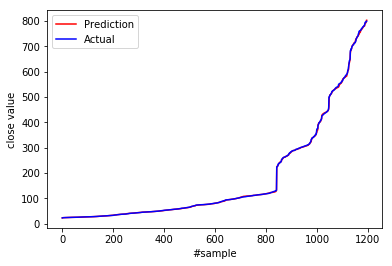

In [42]:
import matplotlib.pyplot as plt2

prediction_sorted = scaler.inverse_transform(model.predict(X_test))
prediction_sorted.sort(axis=0)

Y_test_sorted = scaler.inverse_transform(Y_test.copy().reshape(-1, 1))
Y_test_sorted.sort(axis=0)

plt2.plot(prediction_sorted, color='red', label='Prediction')
plt2.plot(Y_test_sorted, color='blue', label='Actual')
plt2.xlabel('#sample')
plt2.ylabel('close value')
plt2.legend(loc='best')
plt2.show()